Brian Blaylock  
June 14, 2018

# GLM: Proximity to fires
I am interested in showing how close convective activity is to a fire and if it is getting closer or further away. I will do this using data from the Geostationary Lightning Mapper (GLM).

In [1]:
%matplotlib inline

import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_GOES16.get_GLM import get_GLM_files_for_range, accumulate_GLM
from BB_rose.distancerose import WindroseAxes

In [2]:
eDATE = datetime(2018, 6, 14, 21)
prev30 = eDATE - timedelta(minutes=30)
prev60 = eDATE - timedelta(minutes=60)

GLM = accumulate_GLM(get_GLM_files_for_range(prev60, prev30)) # 30-60 minutes ago
GLM2 = accumulate_GLM(get_GLM_files_for_range(prev30, eDATE)) # 0-30 minutes ago

## Map

In [3]:
# 416 fire in colorado
FIRE = (37.461,-107.808)

In [85]:
m = Basemap(resolution='i', projection='cyl', area_thresh=1500,\
            llcrnrlon=FIRE[1]-3.5, llcrnrlat=FIRE[0]-3.5, \
            urcrnrlon=FIRE[1]+3.5, urcrnrlat=FIRE[0]+3.5)

In [5]:
from pyproj import Geod

In [6]:
miles = 150
meters = 1609.344 * miles

g = Geod(ellps='clrk66')


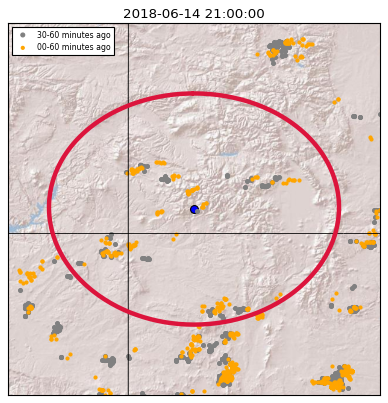

In [117]:
plt.figure(figsize=[6,6])
endlon = []
endlat = []
for i in range(360):
    fwdlon, fwdlat, backaz = g.fwd(FIRE[1], FIRE[0], i, meters)
    endlon.append(fwdlon)
    endlat.append(fwdlat)
m.plot(endlon, endlat, color='crimson', linewidth=4, latlon=True)
m.drawstates()
m.drawcountries()
m.arcgisimage(service='World_Shaded_Relief', xpixels=500, dpi=100)
m.scatter(FIRE[1], FIRE[0], s=50)
m.scatter(GLM['longitude'], GLM['latitude'],
          marker='.',
          s=50,
          color='grey',
          latlon=True,
          label='30-60 minutes ago')
m.scatter(GLM2['longitude'], GLM2['latitude'],
          marker='.',
          s=30,
          color='orange',
          latlon=True,
          label='00-60 minutes ago')

plt.title(eDATE)

leg = plt.legend(scatterpoints=1, framealpha=1, loc=2, fontsize=7)
leg.get_frame().set_linewidth(1)

## Histogram

In [8]:
from math import radians, sin, cos, acos

def distance_two_points(point1, point2):
    slat, slon = point1
    elat, elon = point2
    
    slat = radians(slat)
    slon = radians(slon)
    elat = radians(elat)
    elon = radians(elon)
    
    dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
    # Distance in kilometers
    return dist

In [9]:
# 30-60 minutes ago
distance = []
for i, lon in enumerate(GLM['latitude']):
    distance.append(distance_two_points(FIRE, (GLM['latitude'][i],GLM['longitude'][i])))
distance = np.array(distance)

# convert distance from km to miles
distance = distance * 0.6214


# 0-30 minutes ago
distance2 = []
for i, lon in enumerate(GLM2['latitude']):
    distance2.append(distance_two_points(FIRE, (GLM2['latitude'][i],GLM2['longitude'][i])))
distance2 = np.array(distance2)

# convert distance from km to miles
distance2 = distance2 * 0.6214

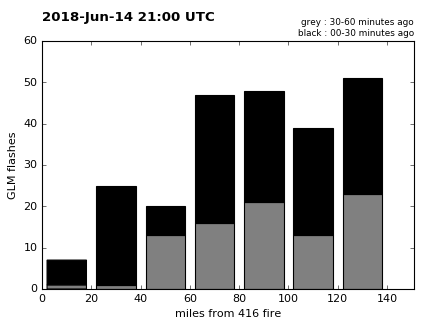

In [107]:
plt.hist([distance[distance<miles],distance2[distance2<miles]],
         stacked=True,
         color=['grey', 'k'],
         bins=range(0,151,20))
plt.xlim(0,151)
plt.xticks(range(0,151,20))
plt.xlabel('miles from 416 fire')
plt.ylabel('GLM flashes')
plt.title(eDATE.strftime('%Y-%b-%d %H:%M UTC\n'), loc='left', fontweight='semibold')
plt.title('\ngrey : 30-60 minutes ago\nblack : 00-30 minutes ago', loc='right', fontsize=8)

## Lightning Rose

In [34]:
# 30-60 minutes ago
# for lightning strikes less then 150 miles away from fire, get the direction and distance
lightning_azimuth = np.array([])
lightning_distance = np.array([])

for i, lon in enumerate(GLM['latitude']):
    fwdaz, bckaz, dist = g.inv(FIRE[1], FIRE[0], GLM['longitude'][i], GLM['latitude'][i])
    if dist/1609.344 <= miles:
        lightning_azimuth = np.append(lightning_azimuth, fwdaz)
        lightning_distance = np.append(lightning_distance, dist/1609.344)

# 0-30 minutes ago
# for lightning strikes less then 150 miles away from fire, get the direction and distance
lightning_azimuth2 = np.array([])
lightning_distance2 = np.array([])

for i, lon in enumerate(GLM2['latitude']):
    fwdaz, bckaz, dist = g.inv(FIRE[1], FIRE[0], GLM2['longitude'][i], GLM2['latitude'][i])
    if dist/1609.344 <= miles:
        lightning_azimuth2 = np.append(lightning_azimuth2, fwdaz)
        lightning_distance2 = np.append(lightning_distance2, dist/1609.344)

In [35]:
lightning_azimuth[lightning_azimuth<0] += 360
lightning_azimuth2[lightning_azimuth2<0] += 360

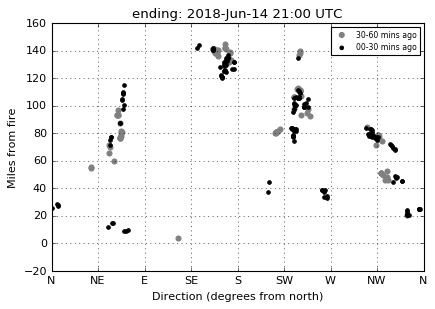

In [82]:
plt.scatter(lightning_azimuth, lightning_distance, color='grey', s=20, label='30-60 mins ago')
plt.scatter(lightning_azimuth2, lightning_distance2, color='k', s=10, label='00-30 mins ago')
plt.xlabel('Direction (degrees from north)')
plt.xlim([0,360])
plt.xticks(range(0,361,45), ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
plt.grid()
plt.title(eDATE.strftime('ending: %Y-%b-%d %H:%M UTC'))

plt.ylabel('Miles from fire')
leg = plt.legend(scatterpoints=1, framealpha=1, loc='best', fontsize=7)
leg.get_frame().set_linewidth(1)

In [14]:
#A quick way to create new windrose axes...
def new_axes():
    fig = plt.figure(figsize=(6,8), dpi=80, facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect, axisbg='w')
    fig.add_axes(ax)
    return ax

#...and adjust the legend box
def set_legend(ax):
    l = ax.legend()
    plt.setp(l.get_texts())
    leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':15})
    leg.draw_frame(False)

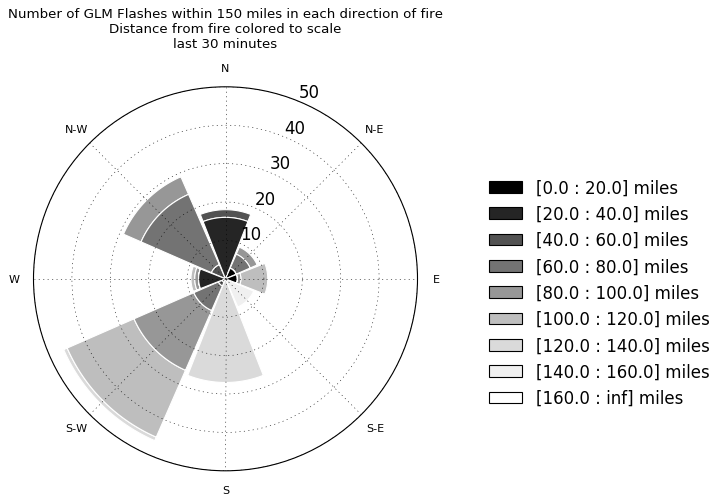

In [49]:
ws = lightning_distance
wd = lightning_azimuth

import matplotlib.cm as cm
ax = new_axes()
#ax.contourf(wd, ws, nsector=16, bins=np.arange(0, miles, 20), cmap=cm.viridis)
ax.bar(wd, ws, nsector = 8, normed=False,
       bins = np.arange(0,miles+21,20),
       opening=.95, edgecolor='w',
       cmap=cm.Greys_r)

leg = plt.legend(loc='bottom left', bbox_to_anchor=(1.8, 0.8),prop={'size':15})
leg.draw_frame(False)

plt.grid(True)
plt.yticks(np.arange(10,105,10))
ax.set_yticklabels(np.arange(10,105,10), fontsize = 15)

table = ax._info['table']
wd_freq = np.sum(table, axis=0)
ax.set_rmax(np.floor(max(wd_freq)/5)*5+5) #set rmax to upper number divisible by 5

plt.title('Number of GLM Flashes within 150 miles in each direction of fire\nDistance from fire colored to scale\nlast 30 minutes\n')

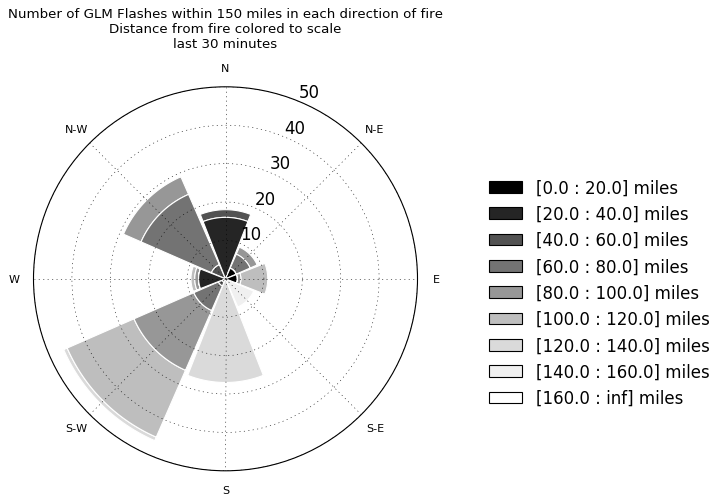

In [50]:
ws = lightning_distance2
wd = lightning_azimuth2

import matplotlib.cm as cm
ax = new_axes()
#ax.contourf(wd, ws, nsector=16, bins=np.arange(0, miles, 20), cmap=cm.viridis)
ax.bar(wd, ws, nsector = 8, normed=False,
       bins = np.arange(0,miles+21,20),
       opening=.95, edgecolor='w',
       cmap=cm.Greys_r)

leg = plt.legend(loc='bottom left', bbox_to_anchor=(1.8, 0.8),prop={'size':15})
leg.draw_frame(False)

plt.grid(True)
plt.yticks(np.arange(10,105,10))
ax.set_yticklabels(np.arange(10,105,10), fontsize = 15)

table = ax._info['table']
wd_freq = np.sum(table, axis=0)
ax.set_rmax(np.floor(max(wd_freq)/5)*5+5) #set rmax to upper number divisible by 5

plt.title('Number of GLM Flashes within 150 miles in each direction of fire\nDistance from fire colored to scale\nlast 30 minutes\n')

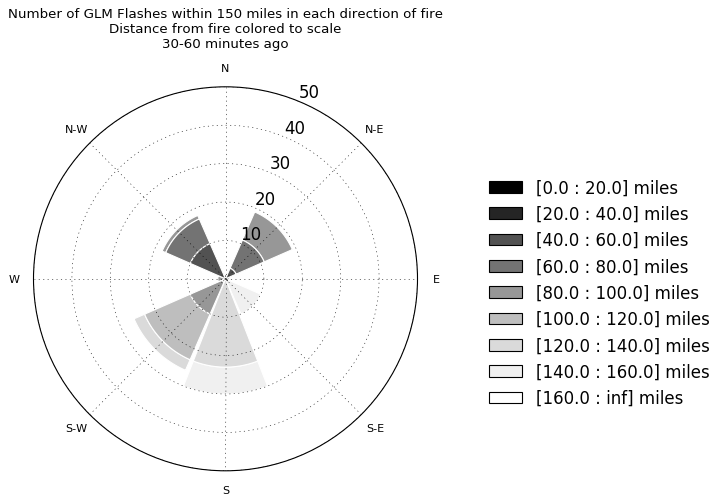

In [52]:
ws = lightning_distance
wd = lightning_azimuth

import matplotlib.cm as cm
ax = new_axes()
#ax.contourf(wd, ws, nsector=16, bins=np.arange(0, miles, 20), cmap=cm.viridis)
ax.bar(wd, ws, nsector = 8, normed=False,
       bins = np.arange(0,miles+21,20),
       opening=.95, edgecolor='w',
       cmap=cm.Greys_r)

leg = plt.legend(loc='bottom left', bbox_to_anchor=(1.8, 0.8),prop={'size':15})
leg.draw_frame(False)

plt.grid(True)
plt.yticks(np.arange(10,105,10))
ax.set_yticklabels(np.arange(10,105,10), fontsize = 15)

table = ax._info['table']
wd_freq = np.sum(table, axis=0)
ax.set_rmax(50) #set rmax to upper number divisible by 5

plt.title('Number of GLM Flashes within 150 miles in each direction of fire\nDistance from fire colored to scale\n30-60 minutes ago\n')